In [1]:
import os
from pathlib import Path
from cotnav.models.vlms import infer_registry
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
# model_name = "o3"
# model_name = "o4-mini"
# model_name = "gpt-5"
# model_args = {
#     "reasoning": {"effort": "low"},
#     "text": {"verbosity": 'low'},
#     "tools": [{"type": "code_interpreter", "container": {"type": "auto"}}],
#     # "max_output_tokens": 384,
# }

model_name = "gpt-4o-mini"
model_args = {
    "text": {"verbosity": 'medium'},
    "tools": [{"type": "code_interpreter", "container": {"type": "auto"}}],
    # "max_output_tokens": 384,
}

vlm_cfg = {
    "name": "openai",  # resolved by infer_registry.get(...)
    "provider_kwargs": {
        "model": model_name,
        "api_key": os.environ["OPENAI_API_KEY"],
        "timeout": 90.0,
        "default_model_args": model_args
    },
    "generate_defaults": {
        "instructions": "Answer concisely and focus on drivable-space cues."
    },
}

motion_cfg = {
    "max_curvature": 0.6,
    "max_free_path_length": 3.0,
    "num_options": 7,
    "pixels_per_meter": 120.0,
    "colors": [(255, 0, 0), (255, 255, 255), (0, 255, 0)],
    "thickness": 3,
    "endpoint_radius": 4,
    "alpha": 230,
}

annotation_cfg = {
    "thickness": 5,
    "endpoint_radius": 25,
    "overlay_alpha": 0.9,
    "label_font_size": 40,
    "label_font_color": (0, 0, 0),
}

In [3]:
pivot = infer_registry.get("pivot", vlm=vlm_cfg, motion_parameters=motion_cfg)


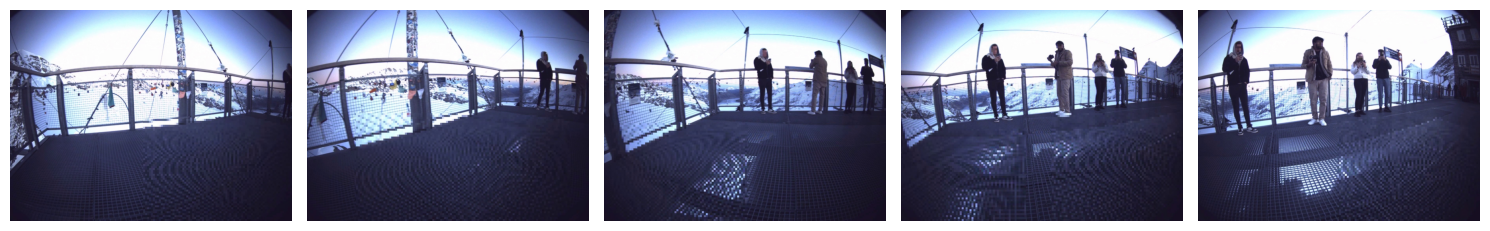

In [4]:
%matplotlib inline
from decord import VideoReader
from decord import cpu, gpu
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

from cotnav.utils.math_utils import (interpolate_se3, se3_matrix, transform_poses)
from cotnav.utils.image_utils import (save_video)
from cotnav.utils.loader_utils import (load_intrinsics, load_odom, load_timestamps, build_transforms)
from cotnav.models.vlms.openaimodel import (
    ChatQuery, get_openai_cost
)

"""BEGIN USER PARAMS"""
MISSION = "mission_2024-11-02-17-18-32"
START_FRAME = 477
END_FRAME = 517
FRAME_STEP = 1
LANGUAGE_CMD = "Go to the railway conductor building."
"""END USER PARAMS"""

mission_dir = Path(f"/robodata/arthurz/Research/cotnav/data/grandtour_raw/{MISSION}")
video_path = mission_dir / "front_camera_lossy.mp4"
ts_path   = mission_dir / "front_camera_timestamps_anymal.csv"
odom_path = mission_dir / "odometry_data_anymal.csv"
info_path = mission_dir / "front_camera_info_anymal.yaml"
tf_path = mission_dir / "tf_static_anymal.yaml"

assert all(p.exists() for p in [mission_dir, video_path, odom_path, info_path, ts_path, tf_path]), "One or more paths do not exist"

calib = load_intrinsics(info_path, tf_path, world_frame="base")

vr = VideoReader(str(video_path), ctx=cpu(0))
batch = vr.get_batch(np.arange(START_FRAME, END_FRAME, FRAME_STEP))
frames = batch.asnumpy()

plt.figure(figsize=(15, 6))
num_plots = 5
frame_indices = np.linspace(0, len(frames) - 1, num_plots, dtype=int)
for i, idx in enumerate(frame_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(frames[idx])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Write batch to video file
save_video(frames, "test_output.mp4", fps=10)

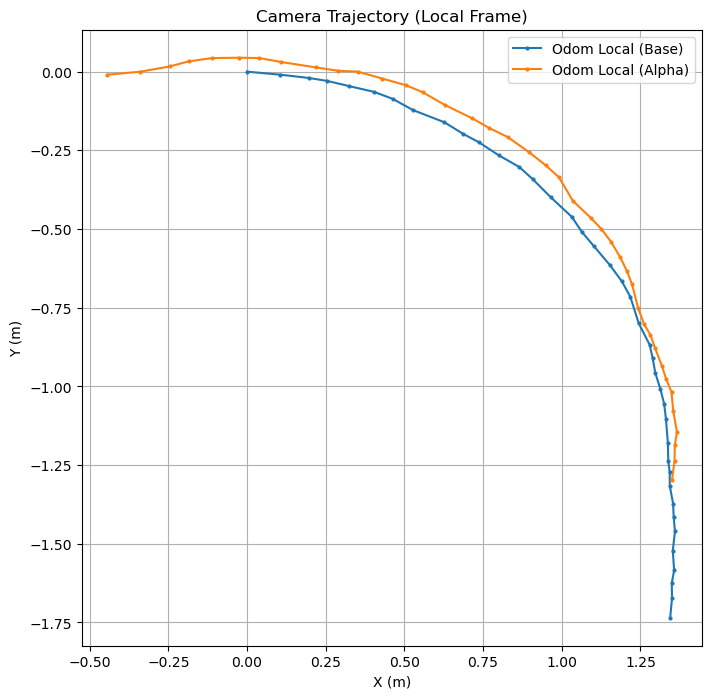

(40, 3)


In [5]:
# Load odometry and convert to local frame
odom = load_odom(odom_path)
cam_ts = load_timestamps(ts_path)
interp_odom = interpolate_se3(cam_ts, odom[:, 0], odom[:, 1:4], odom[:, 4:8])

tm = build_transforms(tf_path)
odom_window = odom[START_FRAME:min(END_FRAME, len(odom))]
T_hesai_odom = se3_matrix(odom_window[:, 1:4], odom_window[:, 4:8])
T_base_hesai = tm.get_transform("hesai_lidar", "base") # tgt, src
T_base_odom = T_hesai_odom @ T_base_hesai
T_base_local = np.linalg.inv(T_base_odom[0]) @ T_base_odom
p_base_local = T_base_local[:, :3, 3]

T_alpha_base = tm.get_transform("base", "alphasense_front_center") # tgt, src

p_alpha_base = -T_alpha_base[:3, 3]
p_alpha_base_homo = np.hstack((p_alpha_base, 1))
p_alpha_local = T_base_local @ p_alpha_base_homo.T
p_alpha_local = p_alpha_local[:, :3]

# Transform odom poses from world to local frame (base)
plt.figure(figsize=(8, 8))
plt.plot(p_base_local[:, 0], p_base_local[:, 1], marker='o', markersize=2, label='Odom Local (Base)')
plt.plot(p_alpha_local[:, 0], p_alpha_local[:, 1], marker='o', markersize=2, label='Odom Local (Alpha)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Camera Trajectory (Local Frame)')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

print(p_alpha_local.shape)

In [6]:
# Compute goal heading angle
def heading_from_start(poses: np.ndarray, start_idx: int, goal_idx: int, *, degrees=False) -> float:
    """
    Compute signed heading angle from the robot's start pose (4x4 SE3) to the goal.
    Positive = CCW from robot's +x axis in the start frame.
    """
    if poses.shape[1:] != (4, 4):
        raise ValueError(f"poses must be 4x4 SE(3) matrix, found {poses.shape[1:]}")

    goal_xyz = poses[goal_idx, :3, 3].reshape(-1)
    if goal_xyz.size not in (2,3):
        raise ValueError("goal_xyz must have 2 or 3 entries (x,y[,z])")
    T_start = poses[start_idx]

    # Start pose world position & yaw
    x0, y0 = T_start[0,3], T_start[1,3]
    R_start = T_start[:3,:3]
    yaw0 = R.from_matrix(R_start).as_euler("zyx", degrees=False)[0]

    # World bearing to goal
    gx, gy = goal_xyz[0], goal_xyz[1]
    bearing_world = np.arctan2(gy - y0, gx - x0)

    # Relative heading = bearing - start_yaw
    heading = (bearing_world - yaw0 + np.pi) % (2*np.pi) - np.pi
    return np.degrees(heading) if degrees else heading

goal_hdg_deg = heading_from_start(T_base_local, 0, -1, degrees=True)  # degrees
print("Goal Heading (deg): ", goal_hdg_deg)
print("T_base_local shape ", T_base_local.shape)
print("Frames shape: ", frames.shape)

Goal Heading (deg):  -52.225546506511634
T_base_local shape  (40, 4, 4)
Frames shape:  (40, 1080, 1440, 3)


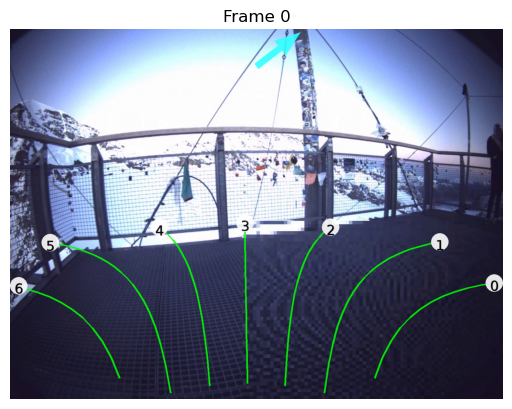

2025-10-07 15:43:17,164 - INFO - HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
2025-10-07 15:43:26,522 - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"


ValueError: Model gpt-4o pricing not known

In [7]:
# %pdb
import logging 

# Response gathering loop
with open("/robodata/arthurz/Research/cotnav/cotnav/models/prompts/openaiprompt.txt", "r") as f:
    system_prompt = f.read()

motion_arcs = pivot.motion_templates()
intermediate_prompts = [
    f"""
    Select the most promising path that follows the command {LANGUAGE_CMD} and explain why in one sentence. Use the format below as described in the system prompt.
    
    goal_idx
    reason for choosing goal
    """,
]
intermediate_prompts.extend(
    ["Given the previous observations and decisions, select the most promising path that follows the command {LANGUAGE_CMD} as before and explain why in one sentence."] * (len(frame_indices)-1)
)
assert len(intermediate_prompts) == len(frame_indices)
 
total_cost = 0
messages = []
annotated_images = []
intermediate_responses = []
for i, idx in enumerate(frame_indices):
    annotated_frame, centers = pivot.annotate_constant_curvature(
        frames[idx], arcs=motion_arcs, calib=calib, **annotation_cfg
    )
    goal_hdg_deg = heading_from_start(T_base_local, idx, -1, degrees=True)
    annotated_frame = pivot.annotate_goal_heading(annotated_frame, goal_hdg_deg)
    plt.figure()
    plt.imshow(np.array(annotated_frame))
    plt.axis('off')
    plt.title(f"Frame {idx}")
    plt.show()

    prompt = intermediate_prompts[i]
    messages.append(ChatQuery("text", "user", prompt))
    messages.append(ChatQuery("image", "user", annotated_frame))

    response = pivot.vqa(system_prompt, messages)
    stage_response = ChatQuery("text", "assistant", response.output_text)
    messages.append(stage_response)
    intermediate_responses.append(response.output_text)
    cost, cost_breakdown = get_openai_cost(
        model_name,
        response.usage.input_tokens - response.usage.input_tokens_details.cached_tokens,
        response.usage.input_tokens_details.cached_tokens,
        response.usage.output_tokens
    )
    total_cost += cost
    logging.info(f"Cost for step {i}: ${cost:.6f}")
    logging.info(f"Cost breakdown: {cost_breakdown}")

logging.info(f"Total cost: ${total_cost:.6f}")

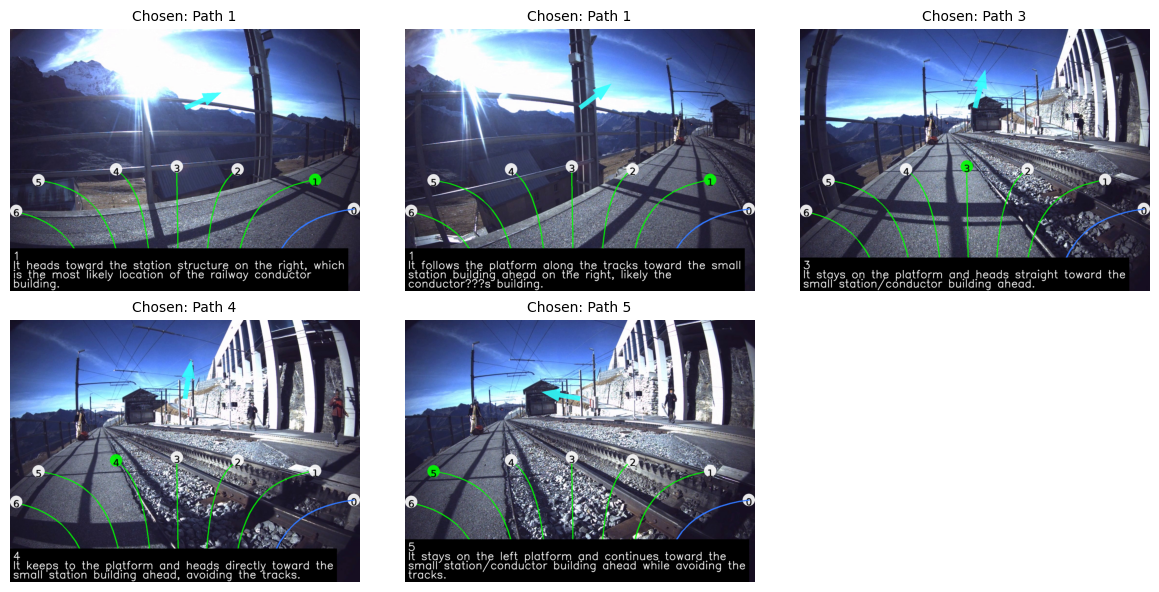

In [ ]:
import re, math, cv2, textwrap
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from PIL import ImageDraw
from cotnav.geometry.camera import project_to_pixel

def _draw_arc_blue(
    img_pil,
    arc,
    calib,
    *,
    z_base: float = -0.4,
    color=(50, 120, 255, 255),   # blue RGBA
    thickness: int = 5,
    max_len_m: float = 6.0,
    samples_per_meter: int = 10,
):
    """Sample an arc in base frame, project to pixels, and draw as a blue polyline."""
    xy = _sample_arc_xy(arc, max_len_m=max_len_m, samples_per_meter=samples_per_meter)  # (N,2)
    if xy.shape[0] < 2:
        return img_pil

    # lift to XYZ and project
    xyz = np.c_[xy, np.full((xy.shape[0], 1), z_base, dtype=np.float32)]
    uv, vis = project_to_pixel(xyz, calib)
    uv_int = [(int(u), int(v)) for (u, v), ok in zip(uv, vis) if ok]
    if len(uv_int) < 2:
        return img_pil

    draw = ImageDraw.Draw(img_pil)
    for a, b in zip(uv_int[:-1], uv_int[1:]):
        draw.line([a, b], fill=color, width=int(thickness))
    return img_pil

def _sample_arc_xy(arc, max_len_m: float, samples_per_meter: int = 10) -> np.ndarray:
    """Return Nx2 XY samples (in base frame) along arc up to max_len_m."""
    s_end = float(min(max_len_m, getattr(arc, "length", max_len_m)))
    n = max(2, int(samples_per_meter * max(0.05, s_end)))
    s_vals = np.linspace(0.0, s_end, n)
    return np.array([arc.xy_at_s(float(s)) for s in s_vals], dtype=np.float32)  # (N,2)

def _hausdorff_xy(A: np.ndarray, B: np.ndarray) -> float:
    """Symmetric Hausdorff distance between two polylines A(N,2) and B(M,2)."""
    if A.size == 0 or B.size == 0: 
        return np.inf
    D = cdist(A, B)  # (N,M)
    return float(max(D.min(axis=1).max(), D.min(axis=0).max()))

def _gt_local_polyline_from_odom(odom: np.ndarray, i: int, lookahead_m: float = 6.0) -> np.ndarray:
    """
    Transform global odometry to the local frame of pose i and return a short
    forward polyline (x,y) over ~lookahead_m along-track distance.
    """
    from scipy.spatial.transform import Rotation as R
    # Build T_current (world->current frame inverse will localize everything)
    xyz_i = odom[i, 1:4]
    q_wxyz_i = odom[i, 4:8]
    T_curr = se3_matrix(xyz_i[None, :], q_wxyz_i[None, :])[0]
    T_inv = np.linalg.inv(T_curr)
    odom_local = transform_poses(odom, T_inv)  # (N,8) in current frame

    # Take future segment starting at i
    xy = odom_local[:, 1:3]
    seg = xy[i:]
    if len(seg) < 2:
        return seg

    d = np.sqrt(((np.diff(seg, axis=0))**2).sum(axis=1))
    cum = np.concatenate([[0.0], np.cumsum(d)])
    k = int(np.searchsorted(cum, lookahead_m, side="right"))
    k = max(1, min(k, len(seg)-1))
    return seg[:k+1]  # (K,2)

def extract_path_index(s: str):
    m = re.search(r'\b\W*?(\d+)\b', s, flags=re.I)
    return int(m.group(1)) if m else None

# --- 2) Small helper: draw wrapped instruction text with OpenCV ---
def draw_instruction_text(pil_img, text, margin=10, font_scale=0.6, thickness=2):
    """
    Draws instruction text at the bottom of the image with a simple black box background.
    Uses OpenCV; returns a PIL.Image.
    """
    import cv2
    import numpy as np
    from PIL import Image

    # PIL → np (RGB)
    img = np.array(pil_img)
    H, W = img.shape[:2]

    font = cv2.FONT_HERSHEY_SIMPLEX
    color_text = (255, 255, 255)   # white
    color_bg   = (0, 0, 0)         # black

    # Wrap text to fit width
    max_text_width = W - 2 * margin
    lines = []
    for paragraph in text.splitlines():
        if not paragraph.strip():
            lines.append("")  # keep blank lines
            continue
        words = paragraph.split()
        line = ""
        for w in words:
            trial = (line + " " + w).strip()
            (tw, th), _ = cv2.getTextSize(trial, font, font_scale, thickness)
            if tw <= max_text_width:
                line = trial
            else:
                if line:
                    lines.append(line)
                line = w
        if line:
            lines.append(line)

    # Compute block size
    line_height = cv2.getTextSize("Ag", font, font_scale, thickness)[0][1] + 6
    block_height = line_height * max(1, len(lines)) + 2 * margin
    block_width = max(
        (cv2.getTextSize(l or " ", font, font_scale, thickness)[0][0] for l in lines),
        default=0
    ) + 2 * margin

    # Clamp to image
    block_width = min(block_width, W)
    block_height = min(block_height, int(0.35 * H))

    # --- Draw at bottom ---
    y_start = H - block_height
    cv2.rectangle(img, (0, y_start), (block_width, H), color_bg, thickness=-1)

    y = y_start + margin + int(line_height * 0.9)
    for l in lines:
        cv2.putText(img, l, (margin, y), font, font_scale, color_text, thickness, cv2.LINE_AA)
        y += line_height
        if y > H - margin:
            break

    return Image.fromarray(img)


def draw_points_on_image(image, points, color=(0, 255, 0), radius=5):
    for i, (u, v) in enumerate(points):
        if i < 1:
            continue
        cv2.circle(image, (int(u), int(v)), radius, color, -1)
    return image

# --- 3) Plot in a grid with matplotlib (no saving) ---
n = len(frame_indices)
cols = math.ceil(math.sqrt(n))
rows = math.ceil(n / cols)
plt.figure(figsize=(4*cols, 3*rows))

chosen_idxs = [extract_path_index(ir) for ir in intermediate_responses]
for i, idx in enumerate(frame_indices):
    # Use your already-computed motion_arcs/calib/annotation_cfg
    selected = chosen_idxs[i] if chosen_idxs[i] is not None else None

    # Re-annotate with the selected index so the chosen circle is green
    img_annot, _ = pivot.annotate_constant_curvature(
        frames[idx],
        arcs=motion_arcs,
        calib=calib,
        selected_idx=selected,
        **annotation_cfg
    )

    # Compute best matching path
    start_odom = odom[idx:]
    gt_xy = _gt_local_polyline_from_odom(start_odom, i=0, lookahead_m=6.0)
    hd_vals = []
    for arc in motion_arcs:
        arc_xy = _sample_arc_xy(
            arc,
            max_len_m=6.0,
            samples_per_meter=annotation_cfg.get("samples_per_meter", 10),
        )
        hd_vals.append(_hausdorff_xy(gt_xy, arc_xy))

    if len(hd_vals):
        best_idx = int(np.argmin(hd_vals))
        img_annot = _draw_arc_blue(
            img_annot,
            motion_arcs[best_idx],
            calib,
            z_base=float(annotation_cfg.get("z_base", -0.4)),
            thickness=int(annotation_cfg.get("thickness", 4)) + 1,
            max_len_m=6.0,
            samples_per_meter=annotation_cfg.get("samples_per_meter", 10),
        )
    
    # Draw gt odom on image
    # uv, mask = project_to_pixel(, calib)

    goal_hdg_deg = heading_from_start(T_base_local, idx, -1, degrees=True)
    W, H = img_annot.size
    img_annot = pivot.annotate_goal_heading(
        img_annot, goal_hdg_deg,
        center=(int(W*0.5), int(H)*0.3)
    )

    # Overlay the INSTRUCTION text (the prompt), using OpenCV
    img_with_text = draw_instruction_text(
        img_annot,
        intermediate_responses[i],
        margin=12,
        font_scale=1.5,
        thickness=2
    )

    # Show
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(img_with_text)
    title_idx = selected if selected is not None else "-"
    ax.set_title(f"Chosen: Path {title_idx}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()
